In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from xgboost import XGBClassifier as XGB
from  umap import UMAP
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM as ocsvm
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, Multiply, Input, LSTM, GRU, ZeroPadding2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.activations import relu
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import kmeans_plusplus

In [3]:
@keras.saving.register_keras_serializable()
class DataGenerator(tf.keras.layers.Layer):
  """Transform  signal into 2D image"""

  def __init__(self, img_shape, n_f):
    super(DataGenerator, self).__init__()
    self.img_shape = img_shape
    self.n_f = n_f

  @tf.function
  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    fft_sig = tf.signal.fft(tf.cast(inputs, tf.complex64))
    fft_real = tf.math.real(fft_sig)
    fft_imag = tf.math.imag(fft_sig)
    fft_img_real = tf.reshape(fft_real,  shape = (batch_size, self.img_shape[0], self.img_shape[1], self.n_f))
    fft_img_imag = tf.reshape(fft_imag, shape = (batch_size,self.img_shape[0], self.img_shape[1], self.n_f))
    inputs_img = tf.reshape(inputs, shape = (batch_size,self.img_shape[0], self.img_shape[1], self.n_f))
    return tf.concat([fft_img_real, fft_img_imag, inputs_img], axis  = -1)

  def get_config(self):
    config = super(DataGenerator, self).get_config()
    config.update({'img_shape':self.img_shape, 'n_f':self.n_f})
    return config

  def compute_output_shape(self, input_shape):
    return (None, self.img_shape[0], self.img_shape[1], 3*self.n_f)
  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class DataReverser(tf.keras.layers.Layer):
  "Transform 2D image into signal"

  def __init__(self, T_x, n_f, batch_size):
    super(DataReverser, self).__init__()
    self.T_x = T_x
    self.n_f = n_f

  @tf.function
  def call(self, inputs):
    splitted_image = tf.split(inputs,num_or_size_splits = 3 ,axis = -1)
    inputs_img = splitted_image[2]
    inputs_array = tf.reshape(inputs_img, shape = (-1, self.T_x, self.n_f))

    return inputs_array

  def get_config(self):
    config = super(DataReverser, self).get_config()
    config.update({"T_x":self.T_x, "n_f":self.n_f})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class Conv_layer(tf.keras.layers.Layer):
  "Conv_layer for feature extaraction from 2D image of signal"

  def __init__(self, conv_model, autoencoder_status):
    super(Conv_layer, self).__init__()
    self.conv_model = conv_model
    self.conv_model_config = conv_model.to_json()
    self.conv_input = conv_model.input
    #Checking for AutoEncoder status because autoencoder require different conditioning of pre_xgb_model
    if autoencoder_status:
      try:
        self.conv_output = conv_model.get_layer("Middle").output
      except:
        raise MissingLayerName(f""" The layer name "Middle" is not found in the conv_model
                                   ///Ensure that provided conv model has a layer named Middle
                                   "\033[92m'Middle Layer is bottleneck layer
                                   If you are Making ConvLSTM then "Middle" should be the name of extra layer after LSTM output'\033[0m"
                                    """)  from None
    else:
      try:
        self.conv_output = conv_model.get_layer("Flatten").output
      except :
        raise MissingLayerName(f""" The layer name "Flatten" is not found in the conv_model
                                   ///The provided model must include a 'Flatten' layer if it is not an autoencoder.
                                   "\033[92m'Flatten Layer Flattens the input. Does not affect the batch size.'\033[0m" """)  from None
    #Creating a model
    self.pre_xgb_model = Model(inputs = [self.conv_input], outputs = [self.conv_output])

  @tf.function
  def call(self, inputs):
    return self.conv_model(inputs)


  def get_config(self):
    config = super(Conv_layer, self).get_config()
    config.update({'conv_model_config':self.conv_model_config})
    return config

  def compute_output_shape(self, input_shape):
    return self.conv_model.output_shape

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvXGB_layer(tf.keras.layers.Layer):

  def __init__(self, XGB_model, pre_xgb_model):
    super(ConvXGB_layer, self).__init__()
    self.XGB_model = XGB_model
    self.pre_xgb_model = pre_xgb_model


  def _train_forest(self, Conv_stored, y_train):
    self.XGB_model.fit(Conv_stored, y_train)


  def get_config(self):
    config = super().get_config()
    config.update({'pre_xgb_model_config': self.pre_xgb_model.to_json(), 'XGB_param':self.XGB_model.get_params()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvISO_layer(tf.keras.layers.Layer):

  def __init__(self, ISO_model, pre_iso_model):
    super(ConvISO_layer, self).__init__()
    self.ISO_model = ISO_model
    self.pre_iso_model = pre_iso_model

  def _train_forest(self, conv_stored):
    return self.ISO_model.fit(conv_stored)

  def get_config(self):
    config = super().get_config()
    config.update({"ISO_model_config":self.pre_iso_model.get_params(), "pre_iso_model_config":self.pre_iso_model.to_json()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvSVM_layer(tf.keras.layers.Layer):

  def __init__(self, SVM_model, pre_svm_model):
    super(ConvSVM_layer, self).__init__()
    self.SVM_model = SVM_model
    self.pre_svm_model = pre_svm_model

  def _train_SVM(self, conv_stored):
    return self.SVM_model.fit(conv_stored)

  def get_config(self):
    config = super().get_config()
    config.update({"pre_SVM_config":2, "pre_svm_model_config":self.pre_svm_model.to_json()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class InvalidDimensions(Exception):
  "Exception for Invalid dimensioning of Model"
  pass

class NotImplemented(Exception):
  "Exception raised when requierd method or layer intialization is missing"
  pass

class MissingLayerName(Exception):
  "Exception for handling for missing parameters in Conv_layer."
  pass

In [4]:
class IFD:
  """Attributes:
  transformed_img_shape:
  n_f:
  T_x:
  num_pred:
  batch_size:
  replace_part:"""

  def __init__(self, transformed_img_shape, n_f, T_x,  num_pred, batch_size = 32, replace_part = True):
    self.transformed_img_shape = transformed_img_shape
    self.n_f = n_f
    self.T_x = T_x
    self.num_pred= num_pred
    self.batch_size = batch_size
    self.replace_part = replace_part

  def set_conv_layer(self, conv_model, auto_encoder = False) -> None:
    self.conv_layer = Conv_layer(conv_model, auto_encoder)
    self.conv_model_input = conv_model.input_shape
    self.conv_model_output = conv_model.output_shape
    self.auto_encoder_status = auto_encoder
    print("'\033[92mconv_layer is created \033[0m'")

  def set_Data_generator(self) ->None:
    self.data_generator = DataGenerator(self.transformed_img_shape, self.n_f)
    self.data_generator_output = self.data_generator.compute_output_shape((self.batch_size, self.T_x, self.n_f))
    print("'\033[92mDataGenerator is created \033[0m'")
######################################################################################################################################################################
  def conditions_check(self):
    "Mehtod to check conditions for proper alignment of different layers together"
    N, M = self.transformed_img_shape
    if N*M != self.T_x:
      raise InvalidDimensions(f"Size of Image should match the time step length of signal {N*M} != {self.T_x}")
    if not hasattr(self, "conv_model_input"):
      raise NotImplemented(f"""First initialize the conv layer using {type(self).__name__}.set_conv_layer() method.
       IFD's object has no attribute with name conv_model_input""")

    if not hasattr(self, "data_generator_output"):
      raise NotImplemented(f"First initialize the Data Generator Layer using {type(self).__name__}.set_Data_Generator() method")

    if not hasattr(self, "conv_model_output"):
      raise NotImplemented(f"First initialize the conv layer using {type(self).__name__}.set_conv_layer() method")

    if self.conv_model_input != self.data_generator_output:
      raise InvalidDimensions(f"Input of Conv model doesn't match the output of DataGenerator Layer//{self.conv_model_input}!= {self.data_generator_output}")

    if self.auto_encoder_status == False and self.conv_model_output[-1] != self.num_pred:
      if len(self.conv_model_output)!= 2:
        raise NotImplemented(f"""//Please do auto_encoder == True if you are using auto encoder architecture for unsupervised learning""")
      else:
        raise InvalidDimensions(f"conv_model_output should be equal to the num of predictions in this case {self.num_pred}")

    if self.auto_encoder_status == True and self.conv_model_output != self.conv_model_input:
      raise InvalidDimensions(f"Output shape  of conv model should be equal to input shape for autoencoder// In these Case {self.conv_model_output} != {self.conv_model_input}")

    ###Checking conditions for AutoEncoder
    ##TO DO
    if self.auto_encoder_status == True:
      pass
    return True
##########################################################################################################################################################################
  def create_and_train_ConvXGB(self, created_model, XGB_model, X_train, y_train):

    "Use this method after trainig to remove the fnn layer and fit XGB model"
    if self.replace_part == True and created_model.weights:
      pre_xgb_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvXGB model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_xgb_generator(inp)

      if self.auto_encoder_status == True:
        pre_xgb_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_xgb_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0]) #Flattening after middle layer in autoencoder for fitting xgb model
        side_xgb_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        side_xgb_model.summary()
        Conv_stored = side_xgb_model(X_train)
      else:
        pre_xgb_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_xgb_model(generated_data)
        side_xgb_model = Model(inputs = [inp], outputs = [conv_output])
        side_xgb_model.summary()
        Conv_stored = side_xgb_model(X_train)[0]

      ConvXGB = ConvXGB_layer(XGB_model, side_xgb_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvXGB._train_forest(Conv_stored, y_train)


    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvXGB

  def create_and_train_ConvISO(self, created_model, ISO_model, X_train):
    if self.replace_part== True and created_model.weights:
      pre_iso_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvISO model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_iso_generator(inp)

      if self.auto_encoder_status == True:
        pre_iso_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_iso_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0])
        side_iso_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        Conv_stored = side_iso_model(X_train)
      else:
        pre_iso_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_iso_model(generated_data)
        side_iso_model = Model(inputs = [inp], outputs = [conv_output])
        side_iso_model.summary()
        Conv_stored = side_iso_model(X_train)[0]

      ConvISO = ConvISO_layer(ISO_model, side_iso_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvISO._train_forest(Conv_stored)
    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvISO


  def create_and_train_ConvSVM(self, created_model, SVM_model, X_train):
    if self.replace_part  == True and created_model.weights:
      pre_svm_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvSVM model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_svm_generator(inp)

      if self.auto_encoder_status == True:
        pre_svm_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_svm_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0])
        side_svm_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        Conv_stored = side_svm_model(X_train)
      else:
        pre_svm_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_svm_model(generated_data)
        side_svm_model = Model(inputs = [inp], outputs = [conv_output])
        side_svm_model.summary()
        Conv_stored = side_svm_model(X_train)[0]

      ConvSVM = ConvSVM_layer(SVM_model, side_svm_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvSVM._train_SVM(Conv_stored)
    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvSVM

  def create_model(self):
    #Input layer
    inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
    #Checking all conditions
    if self.conditions_check():
      print("\033[92m'DataGenerator and Conv_layer is merged'\033[0m")
    #Data generator
    generated_data = self.data_generator(inp)
    conv_output = self.conv_layer(generated_data)
    if self.auto_encoder_status == True:
      rev_conv_output = DataReverser(self.T_x, self.n_f, self.batch_size)(conv_output)
      model = Model(inputs = [inp], outputs = [rev_conv_output])
    else:
      model = Model(inputs = [inp], outputs = [conv_output])

    return model

###Preparing Dataset

In [5]:
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
data.shape

(4998, 141)

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle = True)

In [8]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
4943,-1.197053,-2.186201,-2.853020,-3.246724,-2.727324,-2.296321,-1.720557,-1.182207,-0.610387,-0.443612,...,-1.911224,-2.372609,-2.782575,-3.511550,-3.850818,-3.592020,-2.380402,-1.678824,-0.591928,0.0
1703,-0.696221,-3.054651,-3.998561,-4.239080,-3.864781,-3.405316,-2.268130,-1.559766,-1.368831,-0.895802,...,1.186998,1.437198,1.619958,1.472911,0.866797,0.790004,1.051055,1.174920,-0.506861,1.0
1699,0.024655,-1.637383,-2.987068,-4.288106,-4.349889,-3.837561,-2.617215,-1.644285,-1.466053,-0.978728,...,0.875868,0.601304,0.257108,0.081215,0.180732,0.878719,0.756452,-0.151513,-1.854454,1.0
3681,-0.921084,-2.325155,-3.372637,-3.996669,-3.952095,-3.417211,-2.993761,-2.124574,-1.433681,-1.277673,...,1.998494,2.087641,1.998494,1.619617,1.552757,1.619617,1.552757,0.995585,0.037251,0.0
3712,0.362855,-0.719485,-1.651560,-2.548252,-3.146248,-3.273331,-2.852880,-2.447119,-1.811252,-1.129857,...,-1.712756,-2.184107,-2.644657,-3.451668,-3.634943,-3.147058,-1.808952,-0.528818,0.445541,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812,0.678227,-1.022985,-2.844690,-4.426350,-4.352098,-3.255079,-2.017896,-1.812041,-1.438093,-0.612453,...,0.965853,0.713652,0.897167,0.784545,0.816349,0.968940,1.467910,1.787449,0.116547,1.0
1909,-1.297482,-2.716717,-3.372679,-4.188830,-4.046358,-3.185263,-1.967592,-1.358858,-1.047685,-0.713377,...,2.030742,1.729692,1.364302,0.830814,-0.277467,-1.349092,-1.883082,-1.335516,-0.964838,1.0
4653,0.770736,0.442524,-0.104220,-0.688673,-1.034451,-1.232610,-1.587479,-1.697152,-1.611499,-1.335995,...,-1.348662,-1.821499,-2.304699,-2.908490,-3.561610,-4.396724,-4.571807,-4.333412,-2.998686,0.0
2732,-0.853461,-3.717124,-4.634893,-4.619456,-3.941424,-2.757432,-1.767491,-1.543308,-0.603877,-0.045180,...,0.941186,0.980062,1.257137,1.257582,1.206327,1.240574,1.553175,1.889712,-0.674659,1.0


In [9]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train

array([[0.47302385, 0.46396818, 0.29249618, ..., 0.34330739, 0.40634682,
        0.40760072],
       [0.51584499, 0.38180687, 0.14550108, ..., 0.72140622, 0.68385534,
        0.41390462],
       [0.57747981, 0.51589009, 0.27529518, ..., 0.68894509, 0.55486822,
        0.31404103],
       ...,
       [0.64126975, 0.71266348, 0.64522046, ..., 0.10184511, 0.14820497,
        0.22924745],
       [0.50240095, 0.31913242, 0.06384735, ..., 0.77673289, 0.75336439,
        0.40146991],
       [0.67659011, 0.78454297, 0.54979927, ..., 0.65019312, 0.50948805,
        0.36492667]])

In [12]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

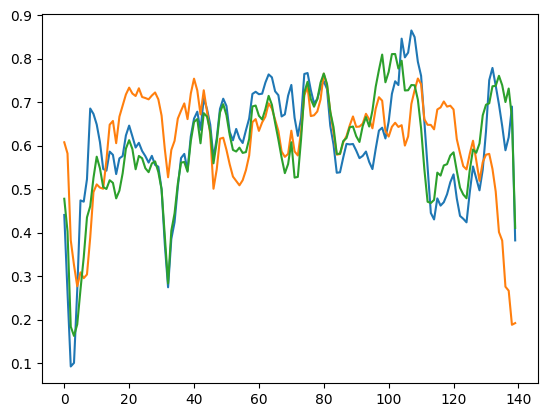

In [13]:
plt.plot(X_train[5])
plt.plot(X_train[25,:])
plt.plot(X_train[125,:])


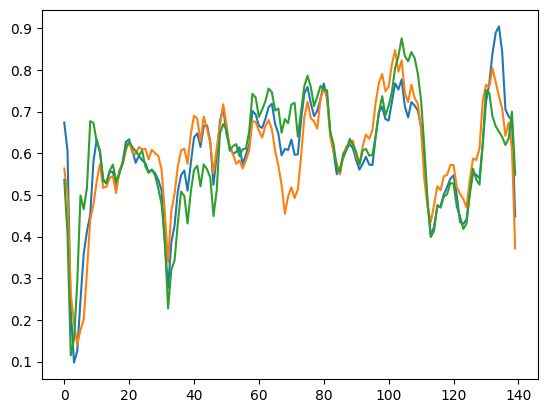

In [14]:
plt.plot(X_test[5])
plt.plot(X_test[25,:])
plt.plot(X_test[125,:])

In [15]:
X_train = tf.expand_dims(X_train, axis = -1)
X_test = tf.expand_dims(X_test, axis = -1)

In [16]:
img_generator = DataGenerator(img_shape = (10, 14), n_f = 1)
img_generator_output = img_generator(X_train)
fft_img_real, fft_img_imag, inputs_img = img_generator_output[:, :, :, 0], img_generator_output[:, :, :, 1], img_generator_output[:, :, :, 2]

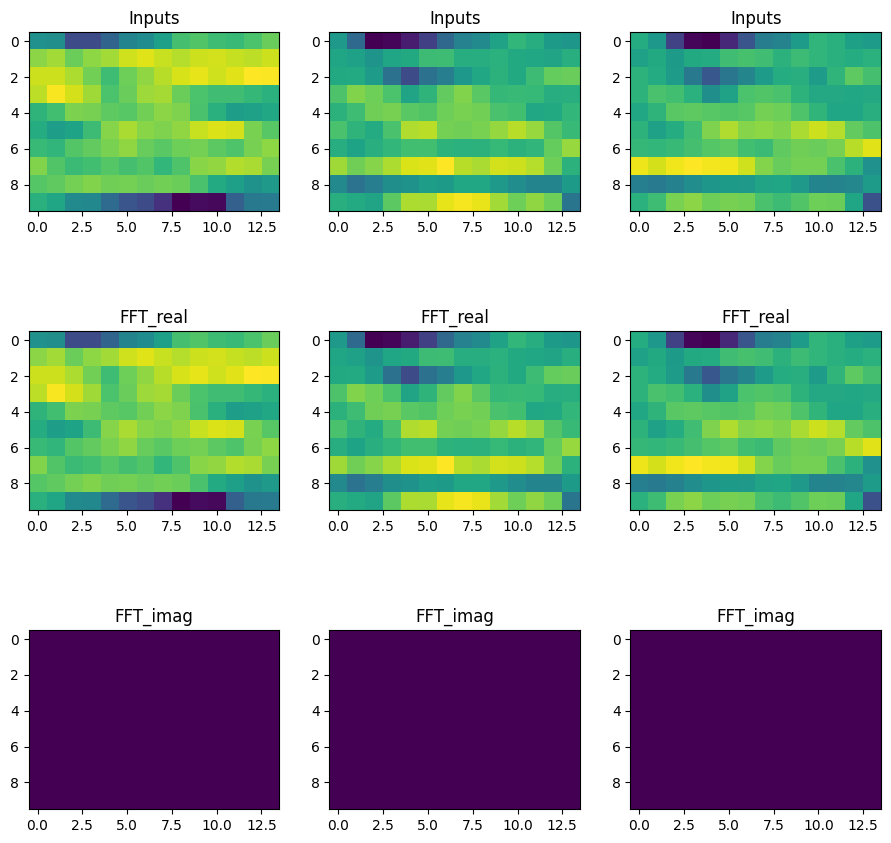

In [17]:
plt.figure(figsize = (11, 11))
for i in range(3):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(inputs_img[i, :, :])
  plt.title("Inputs")
for i in range(4, 7):
  plt.subplot(3,3, i)
  plt.imshow(fft_img_real[i - 4, :, :])
  plt.title("FFT_real")
for i in range(7, 10):
  plt.subplot(3, 3, i)
  plt.imshow(fft_img_imag[i-7,:, :])
  plt.title("FFT_imag")



###Making Supervised Model and Training

In [ ]:
ifd = IFD(transformed_img_shape = (10, 14), n_f = 1, T_x = 140, num_pred = 1, batch_size = 64, replace_part = True)

In [ ]:
#Conv Model
inp = Input(shape = (10, 14, 3))
conv1 = Conv2D(32, (3,3), kernel_initializer = "he_normal")(inp)
conv1_norm = BatchNormalization()(conv1)
conv1_act = relu(conv1_norm)

conv2 = Conv2D(32, (3,3), kernel_initializer = "he_normal", padding = "same")(conv1_act)
conv2_norm = BatchNormalization()(conv2)
conv2_act = relu(conv2_norm)
conv2_act = Dropout(0.4)(conv2_act)
conv2_act = MaxPooling2D((2,2), strides = 2)(conv2_act)

conv3 = Conv2D(64, (3,3), kernel_initializer = "he_normal", padding = "same")(conv2_act)
conv3_norm = BatchNormalization()(conv3)
conv3_act = relu(conv3_norm)

conv4 = Conv2D(64, (3,3), kernel_initializer = "he_normal", padding = "same")(conv3_act)
conv4_norm = BatchNormalization()(conv4)
conv4_act = relu(conv4_norm)
conv4_act = Dropout(0.3)(conv4_act)

fnn_inp = Flatten(name = "Flatten")(conv4_act)
fnn1 = Dense(256, kernel_initializer = "he_normal")(fnn_inp)
fnn1_norm = BatchNormalization()(fnn1)
fnn1_act = Dropout(0.4)(relu(fnn1_norm))

fnn2 = Dense(128, kernel_initializer = "he_normal")(fnn1_act)
fnn2_norm = BatchNormalization()(fnn2)
fnn2_act = Dropout(0.4)(relu(fnn2_norm))

fnn3 = Dense(64, kernel_initializer = "he_normal")(fnn2_act)
fnn3_norm = BatchNormalization()(fnn3)
fnn3_act = Dropout(0.3)(relu(fnn3_norm))

fnn4 = Dense(20, kernel_initializer = "he_normal")(fnn3_act)
fnn4_norm = BatchNormalization()(fnn4)
fnn4_act = relu(fnn4_norm)

out = Dense(1, activation = "sigmoid")(fnn4_act)

conv_model = Model(inputs = [inp], outputs = [out])

In [ ]:
ifd.set_conv_layer(conv_model)
ifd.set_Data_generator()

'conv_layer is created '
'DataGenerator is created '


In [ ]:
model = ifd.create_model()

'DataGenerator and Conv_layer is merged'


In [ ]:
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_34 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_7 (Conv_layer)            │ (None, 1)                   │         504,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,153 (1.92 MB)

 Trainable params: 502,833 (1.92 MB)

 Non-trainable params: 1,320 (5.16 KB)

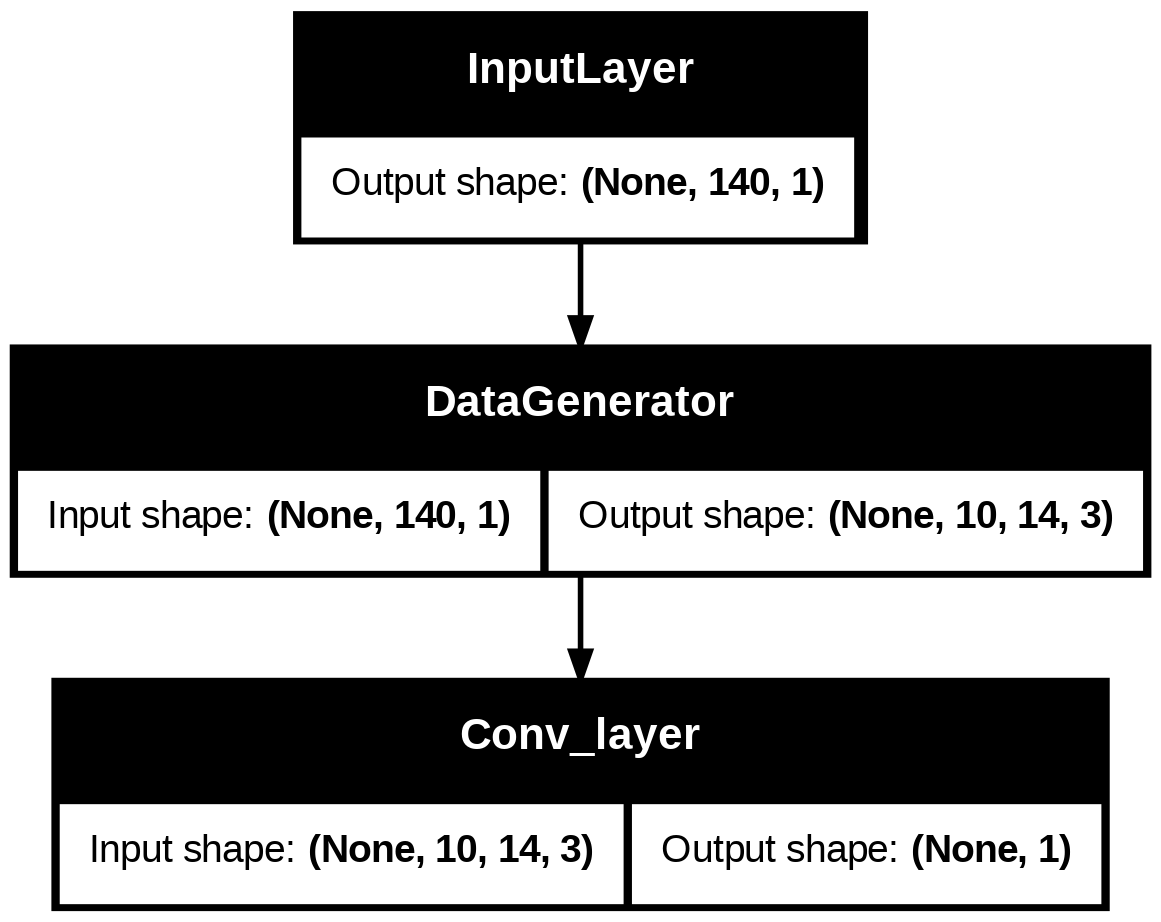

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer = Adam(0.001), loss = "binary_crossentropy", metrics = ['f1_score'])

In [ ]:
y_train = tf.expand_dims(y_train, axis = -1)
y_test = tf.expand_dims(y_test, axis = -1)

In [ ]:
tf.math.reduce_sum(y_train)/len(y_train)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5877938969484743>

In [ ]:
tf.math.reduce_sum(y_test)/len(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.569>

In [ ]:
his = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step - f1_score: 0.7388 - loss: 0.4103 - val_f1_score: 0.7253 - val_loss: 0.1438
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - f1_score: 0.7354 - loss: 0.1211 - val_f1_score: 0.7253 - val_loss: 0.0780
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - f1_score: 0.7463 - loss: 0.0642 - val_f1_score: 0.7253 - val_loss: 0.0609
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - f1_score: 0.7463 - loss: 0.0508 - val_f1_score: 0.7253 - val_loss: 0.0539
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - f1_score: 0.7309 - loss: 0.0467 - val_f1_score: 0.7253 - val_loss: 0.0477
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - f1_score: 0.7441 - loss: 0.0359 - val_f1_score: 0.7253 - val_loss: 0.0575
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - f1_score: 0.7529 - loss: 0.0273 - val_f1_score: 0.7253 - val_loss: 0.0433
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - f1_score: 0.7355 - loss: 0.0286 - val_f1_score: 0.72

In [ ]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - f1_score: 0.7251 - loss: 0.0425


[0.05054106190800667, 0.7253026962280273]

In [ ]:
cm = confusion_matrix(y_test, np.where(model.predict(X_test)> 0.5, 1, 0))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


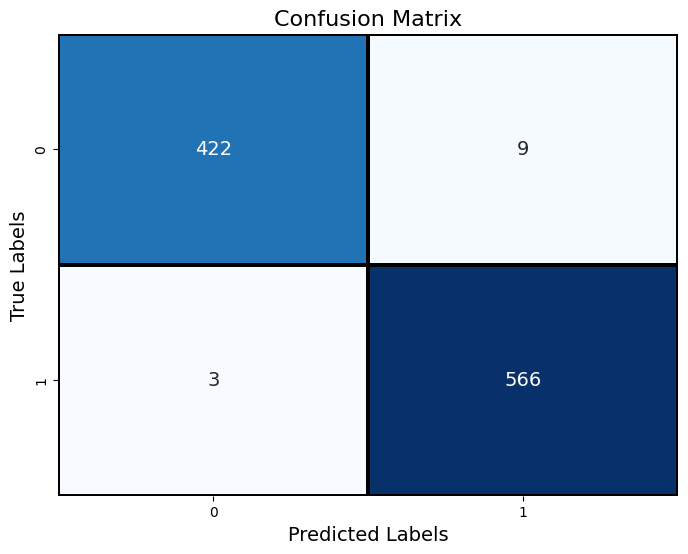

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Text(70.72222222222221, 0.5, 'True Labels')

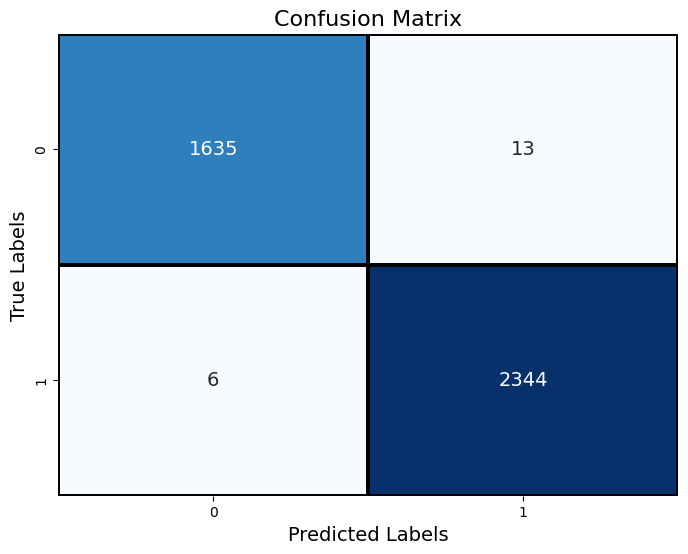

In [ ]:
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_train, np.where(model.predict(X_train)>0.5, 1,0))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title("Confusion Matrix", fontsize = 16)
plt.xlabel("Predicted Labels", fontsize = 14)
plt.ylabel("True Labels", fontsize = 14)

###Using XGBoost

In [ ]:
ConvXGB = ifd.create_and_train_ConvXGB(model, XGB(n_estimators = 300, min_depth = 5, verbosity = 3, booster = "gbtree", early_stopping_round = 20, eval_metrics = ["f1_score"]), X_train, y_train)

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_35 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_32 (Functional)           │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

[17:46:21] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[17:46:21] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:46:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round", "eval_metrics", "min_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[17:46:23] ======== Monitor (0): HostSketchContainer ========
[17:46:23] AllReduce: 0.904531s, 1 calls @ 904531us

[17:46:23] MakeCuts: 0.919567s, 1 calls @ 919567us

[17:46:23] PushRowPage: 0.366385s, 1 calls @ 366385us

[17:47:03] ======== Monitor (0): Learner ========
[17:47:03] Configure: 0.027492s, 1 calls @ 27492us

[17:47:03] EvalOneIter: 0.006825s, 300 calls @ 6825us

[17:47:03] GetGradient: 1.1958s, 300 calls @ 1195798us

[17:47:03] PredictRaw: 0.001274s, 300 calls @ 1274us

[17:47:03] UpdateOneIter: 41.9551s, 300 calls @ 41955113us

[17:47:03] ======== Monitor (0): GBTree ========
[17:47:03] BoostNewTrees: 40.7187s, 300 calls @ 40718716us

[17:47:03] CommitModel: 0.000458s, 300 calls @ 458us

[17:47:03] ======== Monitor (0): HistUpdater ========
[17:47:03] BuildHistogram: 8.22881s, 189 calls @ 8228811us

[17:47:03] EvaluateSplits: 7.91921s, 489 calls @ 7919212us

[17:47:03] InitData: 3.12369s, 300 calls @ 3123689us

[17:47:03] InitRoot: 19.9925s, 300 calls @ 19992517us

[17:4

In [ ]:
flatten_img = tf.reshape(ConvXGB.pre_xgb_model(X_test)[0][:9, :], shape = (9, 48, 32))

In [ ]:
output = ConvXGB.pre_xgb_model(X_test)

In [ ]:
output[0]

<tf.Tensor: shape=(1000, 1536), dtype=float32, numpy=
array([[0.        , 0.36467588, 0.56429195, ..., 0.09517032, 0.        ,
        0.33005303],
       [0.        , 0.56052244, 0.35944805, ..., 0.15075007, 0.        ,
        0.27606785],
       [0.        , 0.4022979 , 0.28120613, ..., 0.07100028, 0.        ,
        0.18180706],
       ...,
       [0.        , 0.34250122, 0.56308365, ..., 0.14610639, 0.06631931,
        0.3943811 ],
       [0.        , 1.1227236 , 0.        , ..., 0.        , 0.        ,
        1.1855818 ],
       [0.        , 0.        , 0.        , ..., 0.25961322, 0.        ,
        0.44444418]], dtype=float32)>

In [ ]:
pred = ConvXGB.XGB_model.predict(output[0])
cm = confusion_matrix(y_test, pred)

[17:47:04] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [ ]:
print(f"f1_score(Convxgb):{f1_score(y_test, pred)}")
# print(f"f1_score(model): {f1_score(y_test, np.where(model.predict(X_test) >= 0.5, 1, 0))}")

f1_score(Convxgb):0.9929947460595446


In [ ]:
print(f"f1_score(model): {f1_score(y_test, np.where(model.predict(X_test) >= 0.5, 1, 0))}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
f1_score(model): 0.987783595113438


In [ ]:
X_test

<tf.Tensor: shape=(1000, 140, 1), dtype=float64, numpy=
array([[[0.42246484],
        [0.43022549],
        [0.34679643],
        ...,
        [0.28036633],
        [0.36264533],
        [0.40153069]],

       [[0.54592596],
        [0.54669477],
        [0.4400596 ],
        ...,
        [0.54517992],
        [0.56961947],
        [0.44898394]],

       [[0.38421448],
        [0.27306184],
        [0.10836383],
        ...,
        [0.66354249],
        [0.67499597],
        [0.28443106]],

       ...,

       [[0.58646937],
        [0.59218444],
        [0.4650315 ],
        ...,
        [0.62258583],
        [0.61558166],
        [0.45137826]],

       [[0.58787767],
        [0.67454524],
        [0.66303012],
        ...,
        [0.82385393],
        [0.85589262],
        [0.596277  ]],

       [[0.54497911],
        [0.50068492],
        [0.33560489],
        ...,
        [0.80103097],
        [0.80694414],
        [0.45826795]]])>

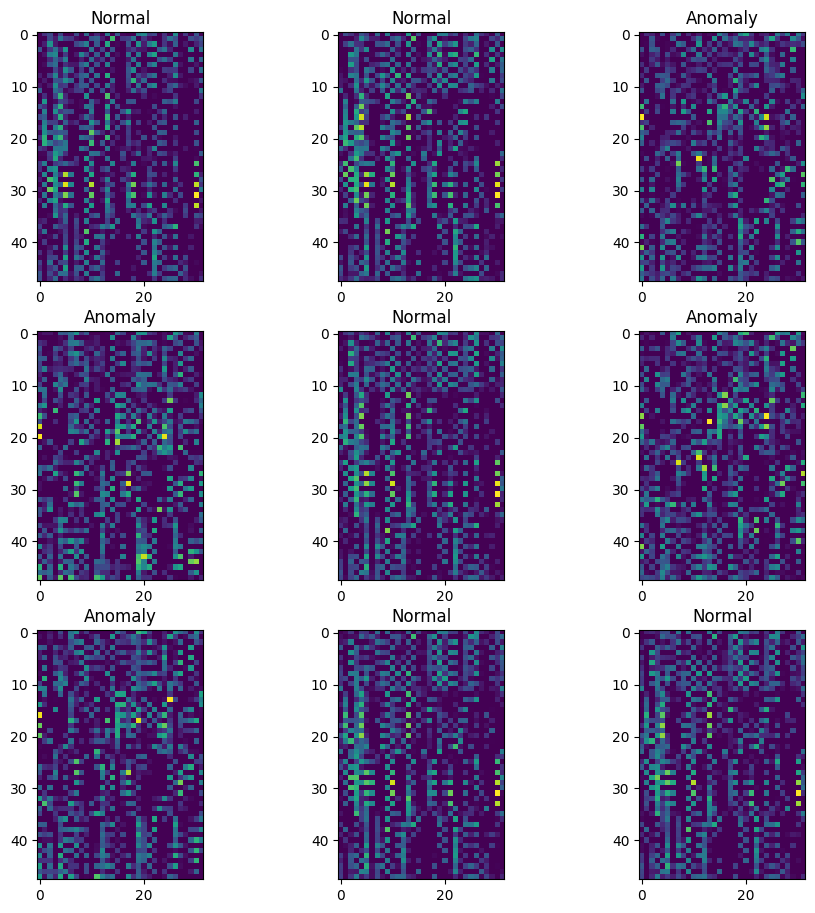

In [ ]:
plt.figure(figsize = (11, 11))
for i in range(9):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(flatten_img[i, :, :])
  plt.title(f"Anomaly" if y_test[i] else "Normal")

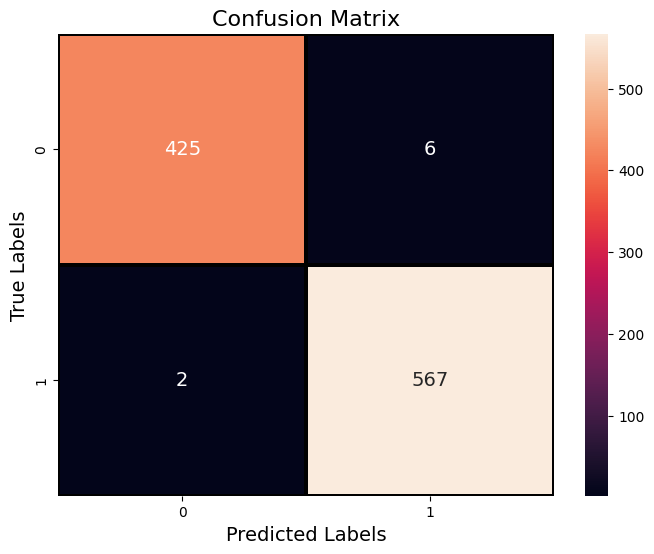

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using Isolation Forest

In [ ]:
#Making ConvISO for Unsupervised learning model
iso_forest = IsolationForest(n_estimators = 300, random_state = 42, contamination = 0.5)
ConvISO = ifd.create_and_train_ConvISO(model, iso_forest, X_train)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_36 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_32 (Functional)           │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
iso_output = ConvISO.pre_iso_model(X_test)

In [ ]:
iso_output[0]

<tf.Tensor: shape=(1000, 1536), dtype=float32, numpy=
array([[0.        , 0.37192163, 0.5442805 , ..., 0.09417185, 0.        ,
        0.32973433],
       [0.        , 0.57073426, 0.34119627, ..., 0.15302163, 0.        ,
        0.27524814],
       [0.        , 0.40792146, 0.26142633, ..., 0.06974858, 0.        ,
        0.18675897],
       ...,
       [0.        , 0.34570768, 0.5420969 , ..., 0.14514264, 0.05941465,
        0.38980705],
       [0.        , 1.1137803 , 0.        , ..., 0.        , 0.        ,
        1.1811155 ],
       [0.        , 0.        , 0.        , ..., 0.2593615 , 0.        ,
        0.44687358]], dtype=float32)>

Isolation isn't performing better because of high contamination in dataset and anomalies are also making a cluster

In [ ]:
f1_score(np.where(ConvISO.ISO_model.predict(iso_output[0]) == -1, 1, 0), y_test)

0.4394366197183099

In [ ]:
np.where(ConvISO.ISO_model.predict(iso_output[0]) == -1, 1, 0)

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,

In [ ]:
reducer = UMAP(random_state = 42)
X_reduced = reducer.fit_transform(tf.squeeze(X_train))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
X_reduced

array([[11.68621  , 11.859761 ],
       [-1.4315683,  9.9466915],
       [11.955583 , 11.384013 ],
       ...,
       [ 5.009042 ,  4.2407627],
       [-4.239597 , 10.01458  ],
       [15.805526 ,  7.9442825]], dtype=float32)

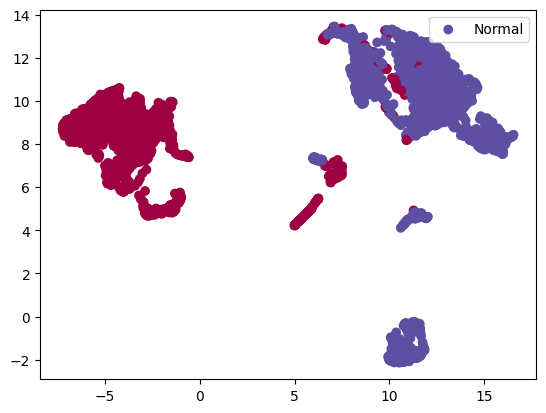

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y_train, cmap = "Spectral")
plt.legend(["Normal", "Anomaly"])

In [ ]:
#lets create  dataset for f1_score with contamination 0.1 or other
X_anomalies_pre = tf.gather(X_train, tf.where(y_train == 1)[:, 0])
X_anomalies_pre = tf.random.shuffle(X_anomalies_pre)
X_anomalies = X_anomalies_pre[:int(0.15*len(X_anomalies_pre))]
X_normal = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_normal = tf.random.shuffle(X_normal)
X_train_iso = tf.concat([X_anomalies, X_normal], axis = 0)
X_train_iso = tf.random.shuffle(X_train_iso)
contamination =  len(X_anomalies)/len(X_train_iso)
contamination

0.176

<ipython-input-258-38618768132a>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")


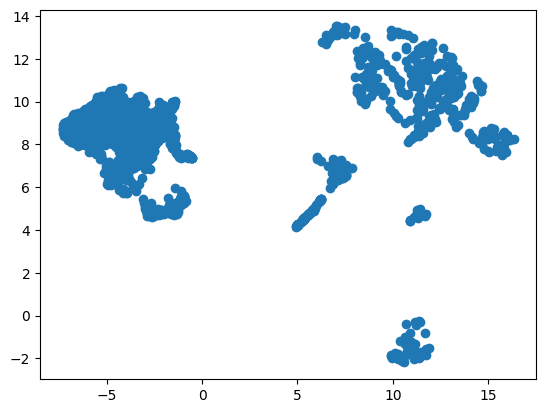

In [ ]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = contamination)
X_train_iso_red = reducer.transform(tf.squeeze(X_train_iso))
plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")

In [ ]:
Conviso2 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_37 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_32 (Functional)           │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
iso_output_2 = Conviso2.pre_iso_model(X_test)
iso_pred_2 = Conviso2.ISO_model.predict(iso_output_2[0])

In [ ]:
cm = confusion_matrix(y_test, np.where(iso_pred_2 == -1, 1, 0))
f1_score(y_test, np.where(iso_pred_2 == -1, 1, 0))

0.7399794450154162

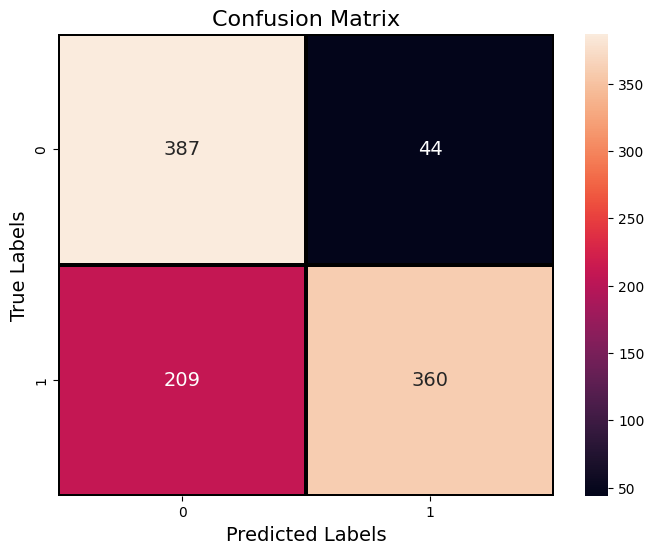

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

<ipython-input-263-bf320b76f144>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")


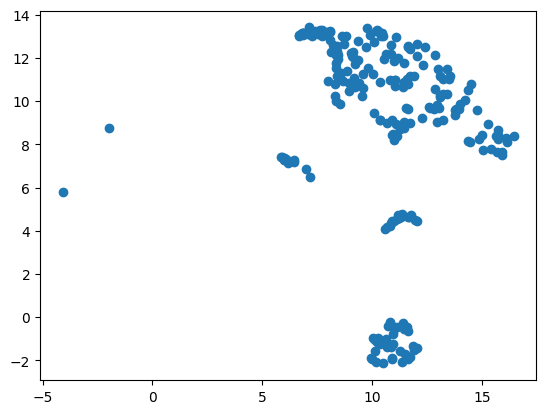

In [ ]:
#lets create more effective dataset for  isolation forest using kmeans_plusplus to get farthest point in dataset
X_anomalies_sep, _ = kmeans_plusplus(np.array(tf.squeeze(X_anomalies_pre)), n_clusters = int(0.1*len(X_anomalies_pre)))
X_anomalies_sep = tf.convert_to_tensor(X_anomalies_sep)
X_anomalies_sep = tf.expand_dims(X_anomalies_sep, axis = -1)
X_anomalies_sep_red = reducer.transform(tf.squeeze(X_anomalies_sep))
plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")

In [ ]:
#lets create dataset with normal points too!!
X_train_iso_2 = tf.concat([X_anomalies_sep, X_normal], axis = 0)
X_train_iso_2 = tf.random.shuffle(X_train_iso_2)
contamination2 =  len(X_anomalies_sep)/len(X_train_iso_2)
contamination2

0.1248008497079129

<ipython-input-265-ecd71b0b0613>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")


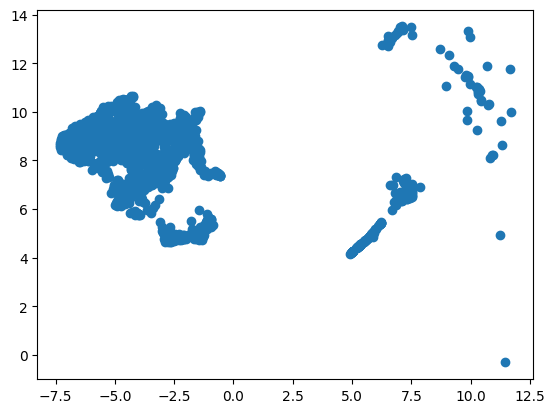

In [ ]:
X_normal_red = reducer.transform(tf.squeeze(X_normal))
plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")

<ipython-input-266-b327f1461c22>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")


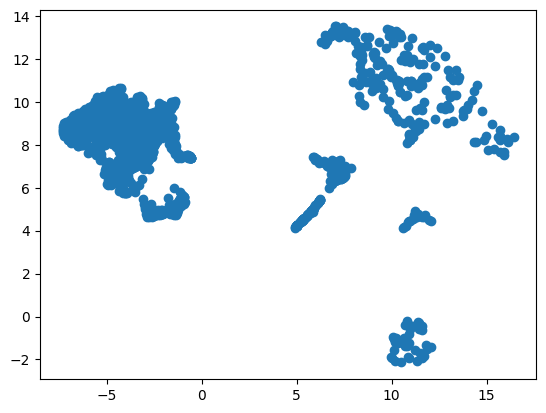

In [ ]:
X_train_iso_2_red = reducer.transform(tf.squeeze(X_train_iso_2))
plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")

In [ ]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = 0.2)
Conviso3 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso_2)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_38 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_32 (Functional)           │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
iso_output_3 = Conviso3.pre_iso_model(X_test)
iso_pred_3 = Conviso3.ISO_model.predict(iso_output_3[0])

In [ ]:
cm = confusion_matrix(y_test, np.where(iso_pred_3 == -1, 1, 0))
f1_score(y_test, np.where(iso_pred_3 == -1, 1, 0))

0.964406779661017

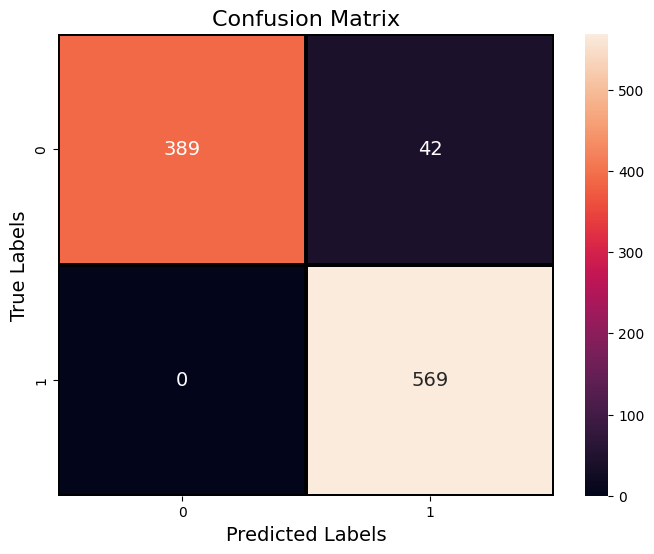

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using  SVM

In [ ]:
X_train_svm = tf.gather(X_train, tf.where(y_train == 0)[:, 0])

In [ ]:
X_train_svm

<tf.Tensor: shape=(1648, 140, 1), dtype=float64, numpy=
array([[[0.43328685],
        [0.40280684],
        [0.24408981],
        ...,
        [0.38802076],
        [0.35783086],
        [0.29127535]],

       [[0.33934579],
        [0.44001178],
        [0.41838365],
        ...,
        [0.76434316],
        [0.69782757],
        [0.48616303]],

       [[0.56197938],
        [0.60000903],
        [0.49715693],
        ...,
        [0.11194949],
        [0.12554881],
        [0.09538759]],

       ...,

       [[0.63555601],
        [0.73366524],
        [0.6726744 ],
        ...,
        [0.06484138],
        [0.05331392],
        [0.02513766]],

       [[0.59023321],
        [0.6657812 ],
        [0.58503717],
        ...,
        [0.24551788],
        [0.35436219],
        [0.31396142]],

       [[0.56142741],
        [0.56571748],
        [0.39530131],
        ...,
        [0.29348913],
        [0.4247399 ],
        [0.38644807]]])>

In [ ]:
svm = ocsvm(degree = 4, gamma = 0.01, nu = 0.01, kernel = "poly", verbose = True)
ConvSVM = ifd.create_and_train_ConvSVM(model, svm, X_train_svm)

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_39 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_32 (Functional)           │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

[LibSVM]

In [ ]:
svm_output = ConvSVM.pre_svm_model(X_test)
pred_svm = ConvSVM.SVM_model.predict(svm_output[0])
pred_svm = np.where(pred_svm == -1, 1, 0)

###Making Unsupervised Model and Training

In [18]:
ifd = IFD(transformed_img_shape = (10, 14), n_f = 1, T_x = 140, num_pred = 0, batch_size = 64, replace_part = True)

In [19]:
#AutoEncoder model
inp = Input(shape = (10, 14, 3), name = "input") #(10, 14)
conv1 = Conv2D(40, (3,3), kernel_initializer = "he_normal", padding = "same")(inp)
conv1_norm = BatchNormalization()(conv1)
conv1_act = relu(conv1_norm)
conv1_act = Dropout(0.3)(conv1_act)

conv2 = Conv2D(30, (3,3), kernel_initializer = "he_normal")(conv1_act)#(8, 12)
conv2_norm = BatchNormalization()(conv2)
conv2_act = relu(conv2_norm)
conv2_act = Dropout(0.3)(conv2_act)

conv3 = Conv2D(15, (3,3), kernel_initializer = "he_normal")(conv2_act)#(6, 10)
conv3_norm = BatchNormalization()(conv3)
conv3_act = relu(conv3_norm)

conv3_act = MaxPooling2D((2, 2), strides = 2, name = "Middle")(conv3_act) #(3, 5)

# Decoder Model (Mirror of Encoder)
deconv1 = Conv2DTranspose(15, (2, 2), strides =2, kernel_initializer="he_normal")(conv3_act)  #(6, 10)
deconv1_norm = BatchNormalization()(deconv1)
deconv1_act = relu(deconv1_norm)

deconv2 = Conv2DTranspose(30, (3, 3), kernel_initializer="he_normal")(deconv1_act)  # (8, 12)
deconv2_norm = BatchNormalization()(deconv2)
deconv2_act = relu(deconv2_norm)
deconv2_act = Dropout(0.3)(deconv2_act)

deconv3 = Conv2DTranspose(40, (3, 3), kernel_initializer="he_normal")(deconv2_act)  # (10, 14)
deconv3_norm = BatchNormalization()(deconv3)
deconv3_act = relu(deconv3_norm)
deconv3_act = Dropout(0.3)(deconv3_act)

# Final Output Layer
output = Conv2DTranspose(3, (3, 3), activation='sigmoid', name="output", padding = "same")(deconv3_act)  # (10, 14, 3)

auto_encoder = Model(inputs = [inp], outputs = [output])



In [20]:
ifd.set_conv_layer(auto_encoder, auto_encoder = True)
ifd.set_Data_generator()

'conv_layer is created '
'DataGenerator is created '


In [21]:
model = ifd.create_model()

'DataGenerator and Conv_layer is merged'


In [22]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_1 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer (Conv_layer)              │ (None, 10, 14, 3)           │          33,613 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_reverser (DataReverser)         │ (None, 140, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,613 (131.30 KB)

 Trainable params: 33,273 (129.97 KB)

 Non-trainable params: 340 (1.33 KB)

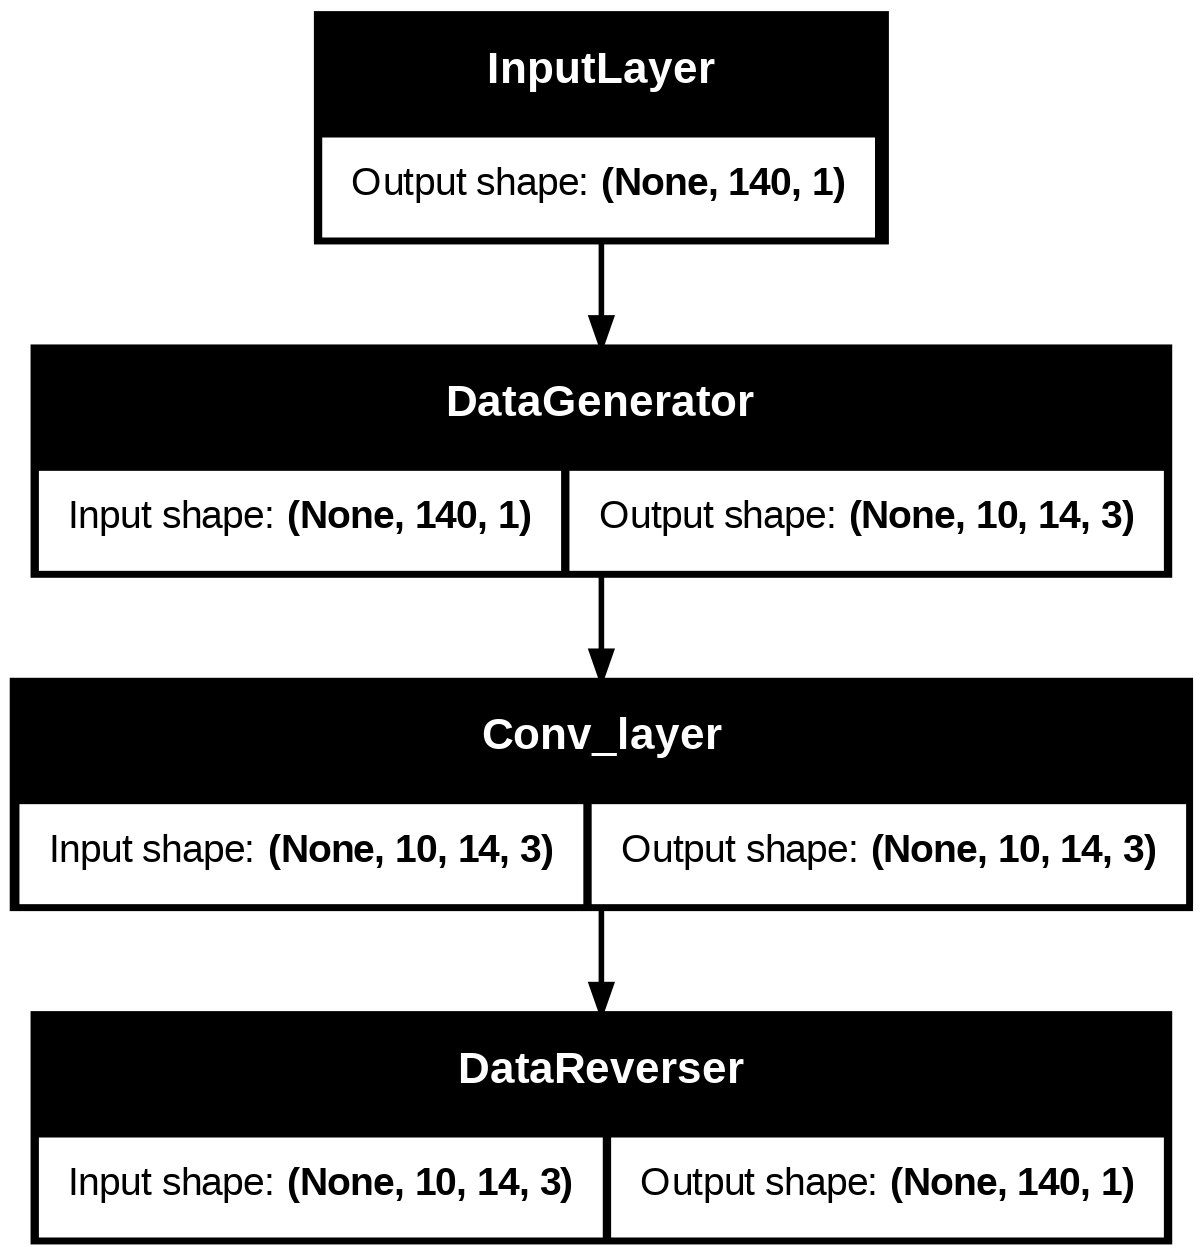

In [23]:
plot_model(model, show_shapes = True)

In [24]:
model.compile(optimizer = Adam(0.001), loss = "mse")

In [25]:
X_train_auto = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_test_auto = tf.gather(X_test, tf.where(y_test == 0)[:, 0])

In [26]:
X_train_auto_copy = tf.identity(X_train_auto)
X_test_auto_copy = tf.identity(X_test_auto)
tf.shape(X_train_auto) == tf.shape(X_train_auto_copy)

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True,  True])>

In [44]:
his = model.fit(X_train_auto, X_train_auto_copy, epochs = 20, batch_size = 64, validation_data = (X_test_auto, X_test_auto_copy))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss

In [45]:
X_test_auto_abnorm = tf.gather(X_test, tf.where(y_test == 1)[:, 0])
model.evaluate(X_test_auto_abnorm, tf.identity(X_test_auto_abnorm))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0146


0.014420611783862114

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


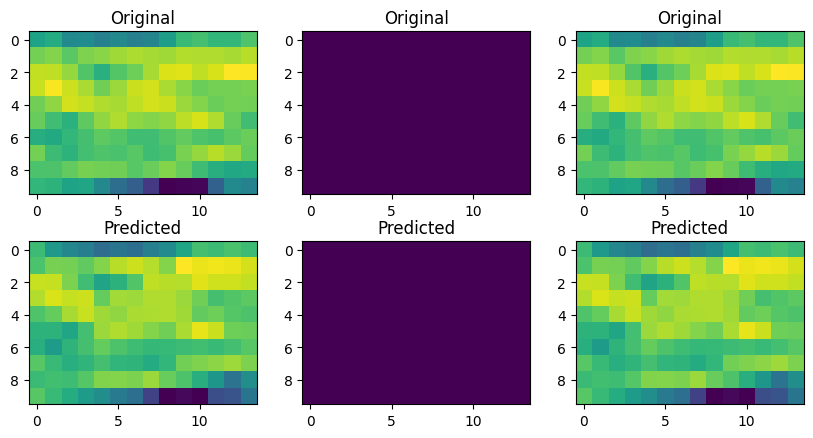

In [46]:
X_test_auto_pred = model.predict(X_test_auto)
generator = DataGenerator(img_shape = (10, 14), n_f = 1)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test_auto)

plt.figure(figsize = (10, 5))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[5, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[5, :, :, i ])
  plt.title("Predicted")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


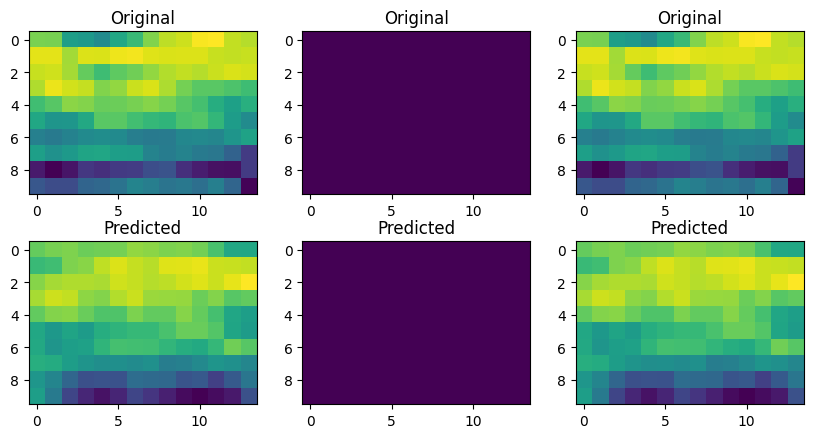

In [47]:
X_test_auto_pred = model.predict(X_test_auto_abnorm)
generator = DataGenerator(img_shape = (10, 14), n_f = 1)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test_auto_abnorm)

plt.figure(figsize = (10, 5))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[6, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[6, :, :, i ])
  plt.title("Predicted")



In [48]:
threshold_list = np.arange(0.0008, 0.015, 0.001)
f1_score_list = []
for threshold in threshold_list:
  y_pred = tf.reduce_sum(tf.square(tf.subtract(X_train, model.predict(X_train))), axis = 1)/140
  y_pred = np.where(y_pred >= threshold , 1, 0)
  f1_score_list.append(f1_score(y_train, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


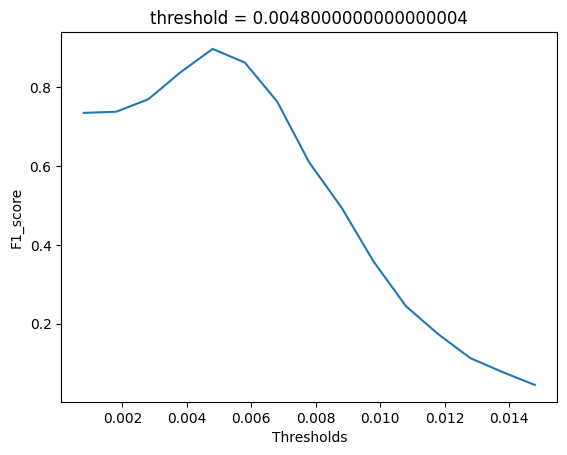

In [49]:
plt.plot(threshold_list, f1_score_list)
plt.ylabel("F1_score")
plt.xlabel("Thresholds")
plt.title("Thresold vs F1_score")
plt.title(f"threshold = {threshold_list[np.argmax(f1_score_list)]}")
plt.show()

In [50]:
threshold_auto = threshold_list[np.argmax(f1_score_list)]
y_pred = tf.reduce_sum(tf.square(tf.subtract(X_train, model.predict(X_train))), axis = 1)/140
y_pred = np.where(y_pred >= threshold_auto , 1, 0)
print(f1_score(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
0.8873323994396638


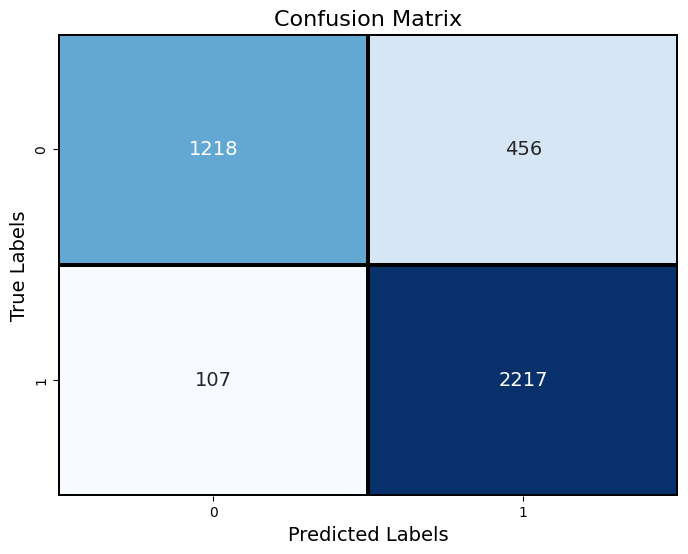

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using XGBoost for Unsupervised Model

In [52]:
ConvXGB_auto = ifd.create_and_train_ConvXGB(model, XGB(n_estimators = 300, min_depth = 5, verbosity = 3, booster = "gbtree", early_stopping_round = 20, eval_metrics = ["f1_score"]), X_train, y_train)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_8 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 3, 5, 15)            │          16,355 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 225)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,355 (63.89 KB)

 Trainable params: 16,185 (63.22 KB)

 Non-trainable params: 170 (680.00 B)

[17:36:27] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[17:36:27] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round", "eval_metrics", "min_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[17:36:27] ======== Monitor (0): HostSketchContainer ========
[17:36:27] AllReduce: 0.1072s, 1 calls @ 107200us

[17:36:27] MakeCuts: 0.120019s, 1 calls @ 120019us

[17:36:27] PushRowPage: 0.041292s, 1 calls @ 41292us

[17:36:30] ======== Monitor (0): Learner ========
[17:36:30] Configure: 0.010976s, 1 calls @ 10976us

[17:36:30] EvalOneIter: 0.003675s, 300 calls @ 3675us

[17:36:30] GetGradient: 0.03191s, 300 calls @ 31910us

[17:36:30] PredictRaw: 0.000942s, 300 calls @ 942us

[17:36:30] UpdateOneIter: 2.83621s, 300 calls @ 2836208us

[17:36:30] ======== Monitor (0): GBTree ========
[17:36:30] BoostNewTrees: 2.73202s, 300 calls @ 2732020us

[17:36:30] CommitModel: 0.000315s, 300 calls @ 315us

[17:36:30] ======== Monitor (0): HistUpdater ========
[17:36:30] BuildHistogram: 0.667745s, 493 calls @ 667745us

[17:36:30] EvaluateSplits: 1.0272s, 793 calls @ 1027195us

[17:36:30] InitData: 0.333427s, 300 calls @ 333427us

[17:36:30] InitRoot: 0.992413s, 300 calls @ 992413us

[17:36:30] Lea

In [53]:
#Lets see the how pre_xgb model output looks like
pre_convxgb_auto_pred_image = tf.reshape(ConvXGB_auto.pre_xgb_model(X_train), shape = (-1, 15,15))

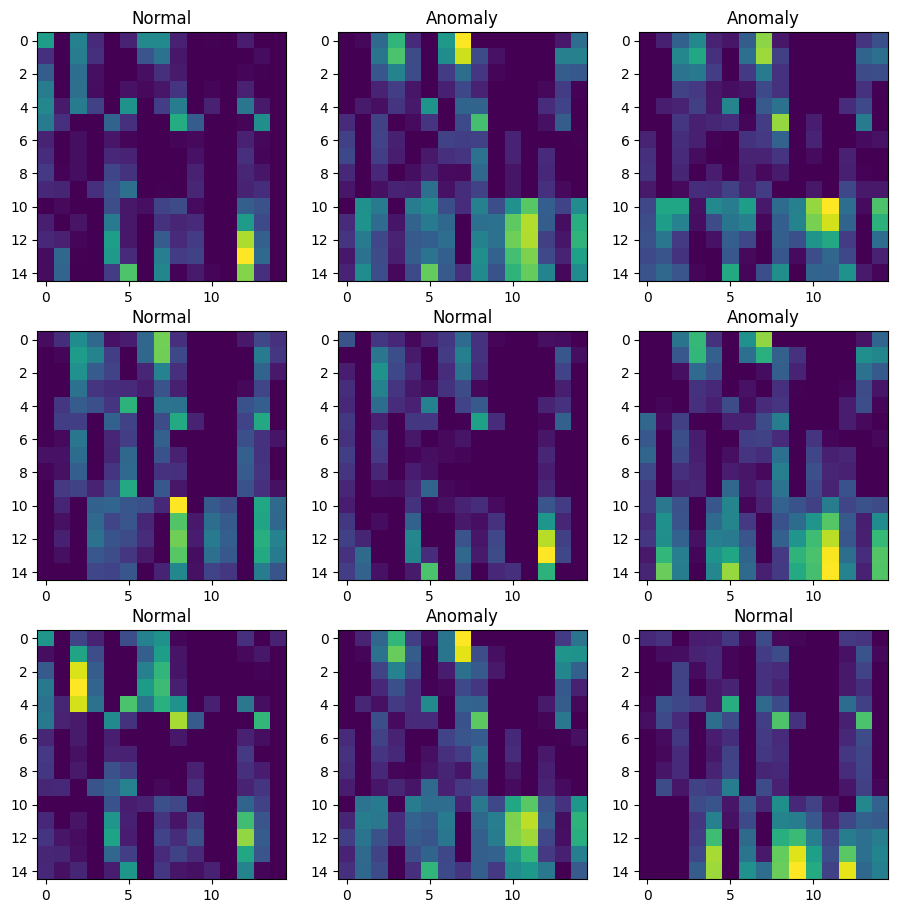

In [54]:
plt.figure(figsize = (11, 11))
for i in range(9):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(pre_convxgb_auto_pred_image[i, :, :])
  plt.title(f"Anomaly" if y_train[i] else "Normal")

In [55]:
pre_convxgb_auto_pred = ConvXGB_auto.pre_xgb_model.predict(X_train)
convxgb_auto_pred = ConvXGB_auto.XGB_model.predict(pre_convxgb_auto_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[17:36:33] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [56]:
print(f1_score(y_train, convxgb_auto_pred))
cm = confusion_matrix(y_train, convxgb_auto_pred)

1.0


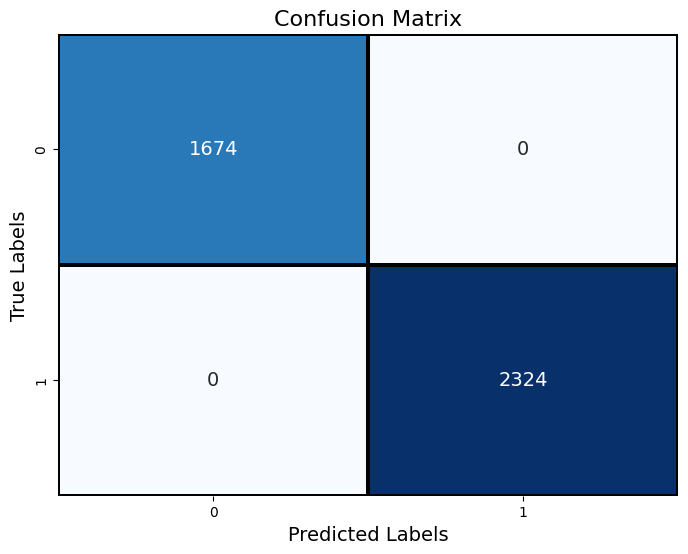

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

In [80]:
pre_convxgb_auto_pred = ConvXGB_auto.pre_xgb_model.predict(X_test)
convxgb_auto_pred = ConvXGB_auto.XGB_model.predict(pre_convxgb_auto_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [82]:
print(f1_score(y_test, convxgb_auto_pred))
cm = confusion_matrix(y_test, convxgb_auto_pred)

0.990748528174937


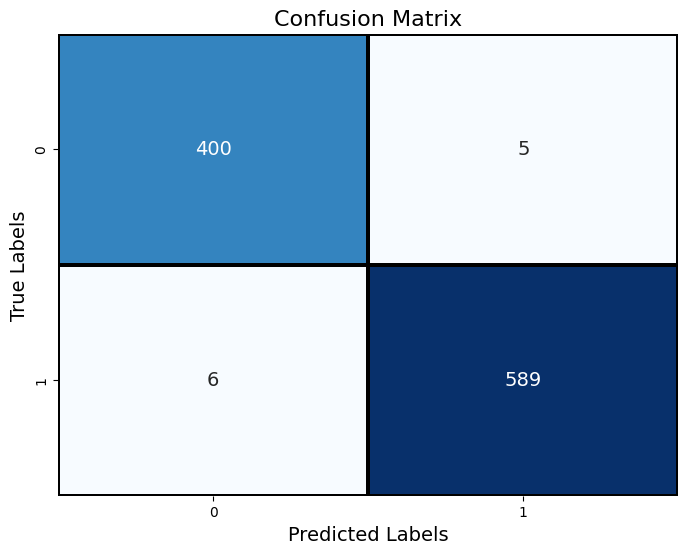

In [83]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using Isolation forest for Unsupervised Model

In [65]:
#Making ConvISO for Unsupervised learning model
iso_forest = IsolationForest(n_estimators = 300, random_state = 42, contamination = 0.5)
ConvISO = ifd.create_and_train_ConvISO(model, iso_forest, X_train)

In [66]:
iso_output = ConvISO.pre_iso_model(X_train)

In [67]:
iso_output

<tf.Tensor: shape=(3998, 225), dtype=float32, numpy=
array([[2.2316575 , 0.        , 1.7619755 , ..., 3.2693777 , 0.5508349 ,
        0.        ],
       [0.        , 0.08265898, 1.2331481 , ..., 1.6315674 , 0.07193696,
        1.7618121 ],
       [0.        , 0.35866034, 1.2652265 , ..., 2.0927987 , 0.28989944,
        0.06055737],
       ...,
       [2.345321  , 0.24649847, 0.        , ..., 6.0124726 , 1.3734691 ,
        0.        ],
       [0.        , 0.10820594, 1.8200252 , ..., 1.435118  , 0.43259588,
        0.87671494],
       [0.21597978, 0.77791876, 0.        , ..., 3.1711187 , 0.54909384,
        5.3692837 ]], dtype=float32)>

Isolation isn't performing better because of high contamination in dataset and anomalies are also making a cluster

In [69]:
f1_score(np.where(ConvISO.ISO_model.predict(iso_output) == -1, 1, 0), y_train)

0.546379828822577

In [71]:
reducer = UMAP(random_state = 42)
X_reduced = reducer.fit_transform(tf.squeeze(X_train))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [72]:
X_reduced

array([[-2.6023784 , 11.337927  ],
       [11.755639  , 11.618746  ],
       [10.383325  , 12.104166  ],
       ...,
       [-0.42923284,  7.8036704 ],
       [13.759453  , 10.998825  ],
       [14.19025   ,  1.0740308 ]], dtype=float32)

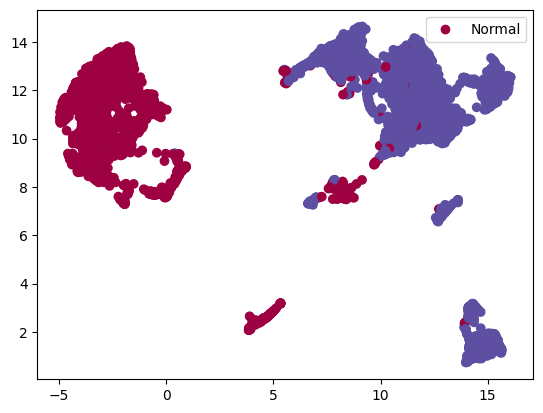

In [73]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y_train, cmap = "Spectral")
plt.legend(["Normal", "Anomaly"])

In [74]:
#lets create  dataset for f1_score with contamination 0.1 or other
X_anomalies_pre = tf.gather(X_train, tf.where(y_train == 1)[:, 0])
X_anomalies_pre = tf.random.shuffle(X_anomalies_pre)
X_anomalies = X_anomalies_pre[:int(0.15*len(X_anomalies_pre))]
X_normal = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_normal = tf.random.shuffle(X_normal)
X_train_iso = tf.concat([X_anomalies, X_normal], axis = 0)
X_train_iso = tf.random.shuffle(X_train_iso)
contamination =  len(X_anomalies)/len(X_train_iso)
contamination

0.17210682492581603

<ipython-input-75-38618768132a>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")


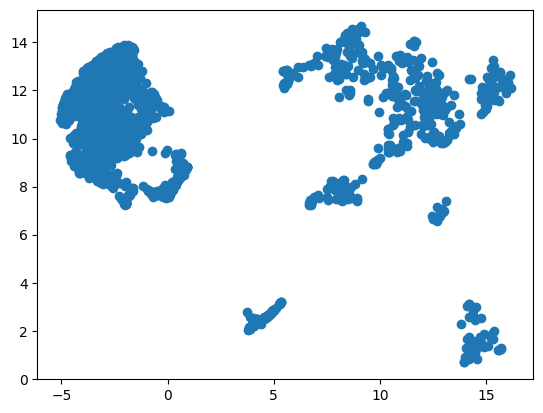

In [75]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = contamination)
X_train_iso_red = reducer.transform(tf.squeeze(X_train_iso))
plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")

In [76]:
Conviso2 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso)

In [77]:
iso_output_2 = Conviso2.pre_iso_model(X_train)
iso_pred_2 = Conviso2.ISO_model.predict(iso_output_2)

In [78]:
cm = confusion_matrix(y_train, np.where(iso_pred_2 == -1, 1, 0))
f1_score(y_train, np.where(iso_pred_2 == -1, 1, 0))

0.5545688914351189

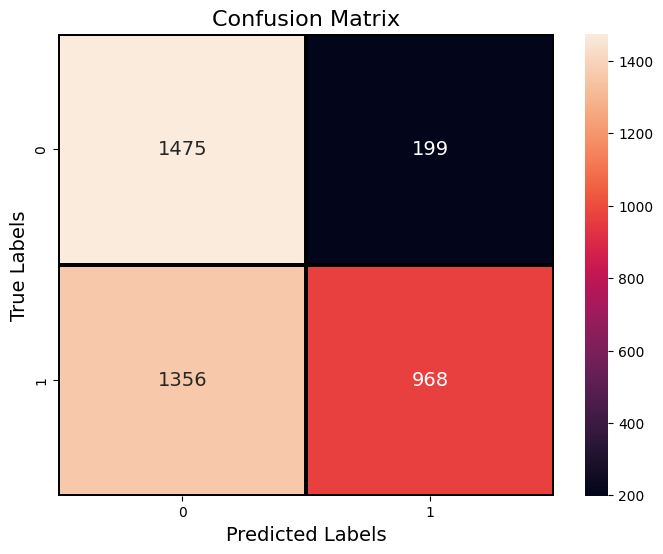

In [79]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

<ipython-input-131-3143e76a2087>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")


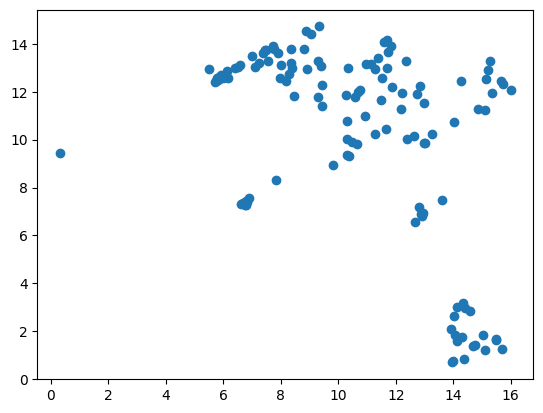

In [131]:
#lets create more effective dataset for  isolation forest using kmeans_plusplus to get farthest point in dataset
X_anomalies_sep, _ = kmeans_plusplus(np.array(tf.squeeze(X_anomalies_pre)), n_clusters = int(0.055*len(X_anomalies_pre)))
X_anomalies_sep = tf.convert_to_tensor(X_anomalies_sep)
X_anomalies_sep = tf.expand_dims(X_anomalies_sep, axis = -1)
X_anomalies_sep_red = reducer.transform(tf.squeeze(X_anomalies_sep))
plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")

In [132]:
#lets create dataset with normal points too!!
X_train_iso_2 = tf.concat([X_anomalies_sep, X_normal], axis = 0)
X_train_iso_2 = tf.random.shuffle(X_train_iso_2)
contamination2 =  len(X_anomalies_sep)/len(X_train_iso_2)
contamination2

0.07051637978900611

<ipython-input-133-ecd71b0b0613>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")


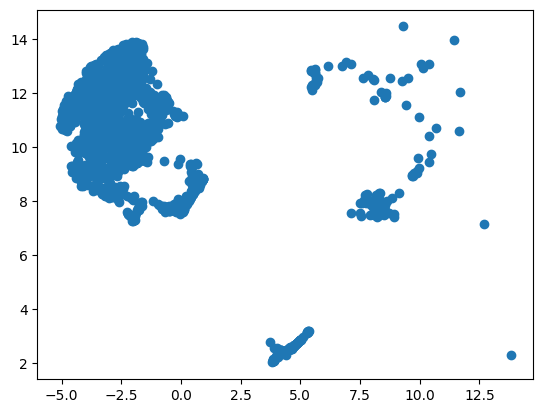

In [133]:
X_normal_red = reducer.transform(tf.squeeze(X_normal))
plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")

<ipython-input-134-b327f1461c22>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")


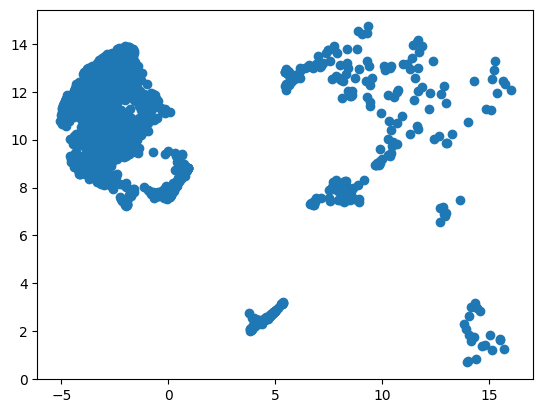

In [134]:
X_train_iso_2_red = reducer.transform(tf.squeeze(X_train_iso_2))
plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")

In [135]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = 0.2)
Conviso3 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso_2)

In [136]:
iso_output_3 = Conviso3.pre_iso_model(X_train)
iso_pred_3 = Conviso3.ISO_model.predict(iso_output_3)

In [137]:
cm = confusion_matrix(y_train, np.where(iso_pred_3 == -1, 1, 0))
f1_score(y_train, np.where(iso_pred_3 == -1, 1, 0))

0.9347193347193348

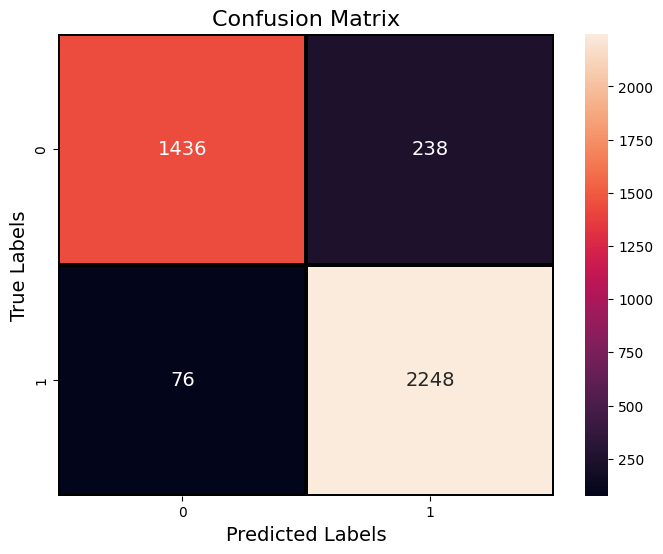

In [138]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using  SVM

In [94]:
X_train_svm = tf.gather(X_train, tf.where(y_train == 0)[:, 0])

In [95]:
X_train_svm

<tf.Tensor: shape=(1674, 140, 1), dtype=float64, numpy=
array([[[0.47302385],
        [0.46396818],
        [0.29249618],
        ...,
        [0.34330739],
        [0.40634682],
        [0.40760072]],

       [[0.49661921],
        [0.45082218],
        [0.22581922],
        ...,
        [0.77668679],
        [0.66641624],
        [0.45422617]],

       [[0.60639587],
        [0.60272954],
        [0.44666675],
        ...,
        [0.4062733 ],
        [0.51817762],
        [0.48448261]],

       ...,

       [[0.47353927],
        [0.50918957],
        [0.40868727],
        ...,
        [0.40374963],
        [0.34620074],
        [0.262287  ]],

       [[0.64462135],
        [0.66259364],
        [0.52102465],
        ...,
        [0.4501103 ],
        [0.45601094],
        [0.40255266]],

       [[0.64126975],
        [0.71266348],
        [0.64522046],
        ...,
        [0.10184511],
        [0.14820497],
        [0.22924745]]])>

In [96]:
svm = ocsvm(degree = 4, gamma = 0.01, nu = 0.01, kernel = "poly", verbose = True)
ConvSVM = ifd.create_and_train_ConvSVM(model, svm, X_train_svm)

[LibSVM]

In [98]:
svm_output = ConvSVM.pre_svm_model(X_test)
pred_svm = ConvSVM.SVM_model.predict(svm_output)
pred_svm = np.where(pred_svm == -1, 1, 0)

###Using Attention Mechanism on Autoencoder

In [63]:
"Attention mechanism in progress"

'Attention mechanism in progress'